In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [2]:
#Base cofficients (now: random!)
BASE_WEIGHTS = { #sum to 1!
    'age': 0.1,
    'income': 0.08,
    'openness': 0.05,
    'conscientiousness': 0.05,
    'extraversion': 0.05,
    'agreeableness': 0.05,
    'neuroticism': 0.05,
    'depressed_mood': 0.03,
    'anhedonia': 0.03,
    'weight_change': 0.03,
    'sleep_disturbance': 0.03,
    'psychomotor': 0.03,
    'fatigue': 0.03,
    'worthlessness': 0.03,
    'concentration': 0.03,
    'suicidal_ideation': 0.03,
    'total_depressive_symptoms': 0.05,
    'education': 0.05,
    'ethnicity': 0.05,
    'gender': 0.1,
    'religion': 0.05
}

MAX_DISTANCES = {
    'age': 100,
    'income': 26722.27,
    'openness': 4,
    'conscientiousness': 4,
    'extraversion': 4,
    'agreeableness': 4,
    'neuroticism': 4,
    'depressed_mood': 3,
    'anhedonia': 3,
    'weight_change': 3,
    'sleep_disturbance': 3,
    'psychomotor': 3,
    'fatigue': 3,
    'worthlessness': 3,
    'concentration': 3,
    'suicidal_ideation': 3,
    'total_depressive_symptoms': 27,
    'education': 1,
    'ethnicity': 1,
    'gender': 1,
    'religion': 1
}

MAX_HOURS = 39
MAX_DISTANCE = sum(BASE_WEIGHTS[key] * MAX_DISTANCES[key] for key in BASE_WEIGHTS)


Test: weights should sum to 1

In [3]:
def test_weights_sum_to_one(weights, tolerance=1e-6):
    total = sum(weights.values())
    if abs(total - 1) > tolerance:
        raise ValueError(f"Weights do not add up to 1! Total = {total:.6f}")
    print(f"Test passed! Weights add up to 1. Total = {total:.6f}")

#test
test_weights_sum_to_one(BASE_WEIGHTS)

Test passed! Weights add up to 1. Total = 1.000000


Set-up

In [4]:
seed = 123
n = 15 #support group size
data = pd.read_csv('synthetic_data.csv')
support_group_data = data.sample(n=n, random_state=seed).reset_index(drop=True)
print(support_group_data)

    age  gender        income  openness  conscientiousness  extraversion  \
0    35    Male   1986.437986  4.765635           4.182005      2.908953   
1    36    Male   2247.857607  4.201509           4.890064      4.920335   
2    38   Other   2032.517510  3.880219           3.544836      4.402572   
3    30  Female   1284.180142  4.229255           4.241311      4.646855   
4    31    Male  30032.884151  4.520139           4.054804      3.027452   
5    36  Female   1550.702487  5.000000           3.010855      3.281155   
6    59  Female   2554.207948  3.276627           3.638708      2.019563   
7    44    Male   4769.860714  3.347078           4.048966      4.484322   
8    45  Female   6813.472149  4.125547           3.554138      3.591246   
9    43    Male   1294.078738  3.319962           3.177704      3.876557   
10   34    Male   2180.259321  4.105312           3.836492      4.357813   
11   44  Female   3304.164565  4.693307           3.314124      4.308008   
12   39    M

Create a graph

In [5]:
G = nx.complete_graph(n)

for i, row in support_group_data.iterrows():
     G.add_node(i, **row.to_dict())

Define the homophily function

In [6]:
def homophily_function(node1, node2, G, weights): #TODO: incorporate euclidean distance?
    '''Homophily function for edge prediction
    The output should be the number of hours the two people in the edge spend together'''

    normalized_total_distance = 0
    max_normalized_total_distance = sum(weights.values())

    for attribute, weight in weights.items():
        value1 = G.nodes[node1].get(attribute)
        value2 = G.nodes[node2].get(attribute)
        max_attribute_distance = MAX_DISTANCES[attribute]

        #handle continuous variables
        if isinstance(value1, (int, float)) and isinstance(value2, (int, float)): #TODO: add handling o NA values
            absolute_distance = abs(value1 - value2)
            normalized_distance = absolute_distance / max_attribute_distance
            weighted_normalized_distance = normalized_distance * weight
            normalized_total_distance += weighted_normalized_distance

        #handle categorical variables
        elif isinstance(value1, str) and isinstance(value2, str):
            normalized_distance = 1 if value1 != value2 else 0
            normalized_total_distance += weight * normalized_distance

    #Convert distance to hours
    #TODO: use a nonmonotonic function here according to Bruggeman
    # Output score between 0 and 1
    score = 1 - (normalized_total_distance / max_normalized_total_distance)
    return round(score, 2)

Assign weights based on the homophily function

In [7]:
for node1, node2 in G.edges():
    weight = homophily_function(node1, node2, G, BASE_WEIGHTS)
    G.edges[node1, node2]['weight'] = weight

Display graph

{(0, 1): Text(0.46421385607257115, 0.04424125999541603, '0.74'),
 (0, 2): Text(0.45615447981882196, 0.31668572977360987, '0.55'),
 (0, 3): Text(0.10320169830125289, -0.25944889080430533, '0.63'),
 (0, 4): Text(0.6420979986760419, -0.3434003499893723, '0.72'),
 (0, 5): Text(0.40914013095018575, -0.5428353232227404, '0.67'),
 (0, 6): Text(-0.023570668750521828, 0.1941496776776038, '0.64'),
 (0, 7): Text(0.7071416448112811, -0.028746052497635455, '0.64'),
 (0, 8): Text(-0.2323469504605216, -0.3265502130899448, '0.62'),
 (0, 9): Text(-0.13296400688521734, -0.11168169791317062, '0.69'),
 (0, 10): Text(-0.03610524679060509, -0.5054477095257278, '0.79'),
 (0, 11): Text(0.1743655656473219, 0.3075315382318743, '0.72'),
 (0, 12): Text(0.21307279111708202, 0.0028263330227534245, '0.71'),
 (0, 13): Text(0.18646026604697447, -0.5589273224079582, '0.71'),
 (0, 14): Text(-0.23802017600801392, 0.0888797371772101, '0.62'),
 (1, 2): Text(0.5060850462688309, 0.6259613410878553, '0.65'),
 (1, 3): Text(0.1

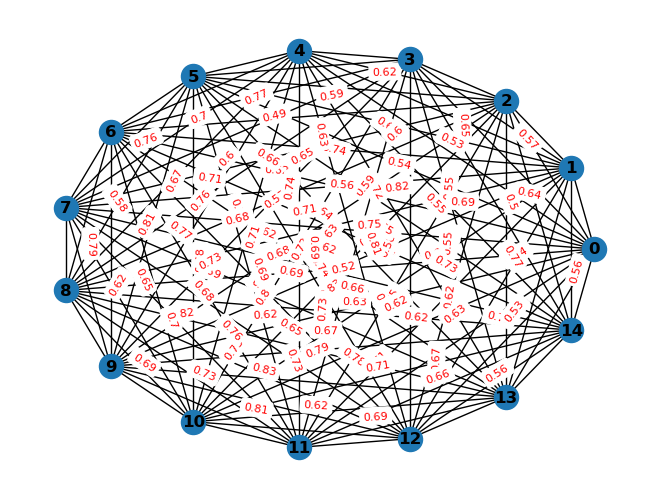

In [8]:
pos=nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=nx.spring_layout(G), edge_labels=edge_labels, font_size=8, font_color='red')


Linear regression to extract coefficients

In [9]:
#data prep

def prepare_regression_data(G, attributes, max_hours):
    '''Prepares data for regression'''
    data = []

    for node1, node2, edge in G.edges(data=True):
        row = {}

        for attr in attributes:
            value1 = G.nodes[node1].get(attr, 0)
            value2 = G.nodes[node2].get(attr, 0)
            max_attribute_distance = MAX_DISTANCES[attr]

            # Absolute differences for continuous attributes
            if isinstance(value1, (int, float)) and isinstance(value2, (int, float)): #TODO: add handling o NA values
                absolute_distance = abs(value1 - value2)
                normalized_distance = absolute_distance / max_attribute_distance
                row[attr] = - normalized_distance

            # Binary differences for categorical attributes
            elif isinstance(value1, str) and isinstance(value2, str):
                row[attr] = - 1 if value1 != value2 else 0 #minus because distance has negative contribution to hours
                
        row['target'] = edge['weight']
        data.append(row)      

    return pd.DataFrame(data)

Regression

In [10]:
attributes = list(support_group_data.columns.values)
regression_data = prepare_regression_data(G, attributes, MAX_HOURS)

X = regression_data[attributes]
Y = regression_data['target']

#fit
model = LinearRegression()
model.fit(X, Y)

recovered_weights = pd.Series(model.coef_, index=attributes)
normalized_recovered_weights = recovered_weights / recovered_weights.sum() #normalize weights
normalized_recovered_weights = normalized_recovered_weights.to_dict() #convert to a dictionary


Comparison

In [11]:
# Combine into a DataFrame for comparison
comparison = pd.DataFrame({
    'Base Weights': BASE_WEIGHTS,
    'Recovered Weights': normalized_recovered_weights
})

# Display the comparison
print(comparison)

                           Base Weights  Recovered Weights
age                                0.10           0.100375
income                             0.08           0.082352
openness                           0.05           0.047621
conscientiousness                  0.05           0.048155
extraversion                       0.05           0.050115
agreeableness                      0.05           0.052978
neuroticism                        0.05           0.052127
depressed_mood                     0.03           0.029010
anhedonia                          0.03           0.032141
weight_change                      0.03           0.030312
sleep_disturbance                  0.03           0.031246
psychomotor                        0.03           0.030094
fatigue                            0.03           0.030219
worthlessness                      0.03           0.028989
concentration                      0.03           0.030476
suicidal_ideation                  0.03           0.0303

Regenerate a graph with recovered weights

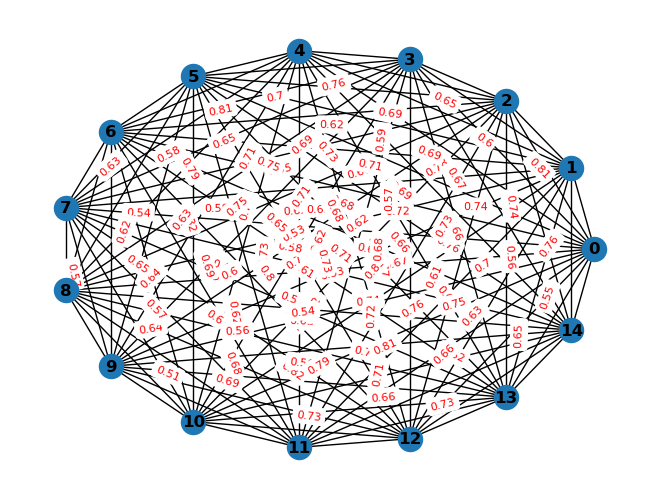

In [12]:
G_recovered = nx.complete_graph(n)

#assign attributes to the recovered graph (same as in the original graph)
for i, row in support_group_data.iterrows():
     G.add_node(i, **row.to_dict())

#assign weights based on homophily function
for node1, node2 in G_recovered.edges():
    weight = homophily_function(node1, node2, G, normalized_recovered_weights)
    G_recovered.edges[node1, node2]['weight'] = weight

#display graph
pos=nx.circular_layout(G_recovered)
nx.draw(G_recovered, pos, with_labels=True, font_weight='bold')
edge_labels = nx.get_edge_attributes(G_recovered, 'weight')
nx.draw_networkx_edge_labels(G_recovered, pos=nx.spring_layout(G_recovered), edge_labels=edge_labels, font_size=8, font_color='red');

Compare original network with recovered

In [13]:
def edge_match(attr1, attr2): #TODO: make this more sophisticated
    res = attr1['weight'] == attr2['weight']
    return res


nx.graph_edit_distance(G, G_recovered, edge_match=edge_match)

11.0

In [14]:
nx.is_isomorphic(G, G_recovered, edge_match=edge_match)

False